In [79]:
#Import Mods
import pandas as pd
import numpy as np

import glob

import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import metpy.calc as mpcalc
from metpy.units import units

from PIL import Image, ImageDraw

In [2]:
#Selected files to create the mask. Second image creates a better mask.

file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                  "thermal/1618762640_000001_right_336x252_14bit.thermal.celsius.csv")


file = pd.read_csv("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/"
                "thermal/1618776148_000001_right_336x252_14bit.thermal.celsius.csv")

In [28]:
#Create image list by unpacking data from CSV and placing in correct spot.

image_array = []

for i in range(file.size):
    if i >= 6:
        data = file.values[i][0]
        data = data.split(';')
        array = np.array(data)
        array = array.astype(np.float)
        image_array.append(array)
        
max_temp = np.max(image_array)
min_temp = np.min(image_array)

x, y = np.where(image_array == max_temp)
print(x, y)
x[0]

[170] [176]


170

In [47]:
#Create mask list with threshold value.
mask_col = []

for j in image_array:
    mask_row = []
    for k in j:
        x, y = np.where(image_array == k)
        
        if ((x[0] >= 160 and x[0] <= 210) and (y[0] >= 150 and y[0] <= 190)):
            
            if k > 20.00:
                mask_row.append(1)
            else:
                mask_row.append(0)
                
        else:
            mask_row.append(0)

    mask_col.append(mask_row)
            
    

In [64]:
#Create mask list with threshold value.
mask_col = []

for j in image_array:
    mask_row = []
    for k in range(len(j)):
        
        if k > 160 and k < 210:
            
            if j[k] > 19.75:
                mask_row.append(1)
            else:
                mask_row.append(0)
                
        else:
            mask_row.append(0)

    mask_col.append(mask_row)
            

In [72]:
#Tranform list into array and convert all true values from 1 to 255 as well as use an unsigned 8-bit integer dtype.
mask_array = np.array(mask_col)
array = np.array(mask_col).astype('uint8')*255
print(mask_array.size)

84672


In [66]:
shape = [(160, 150), (210, 190)]

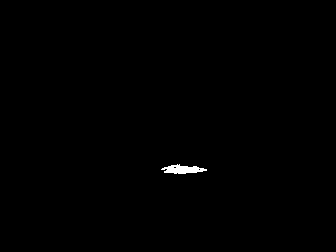

In [67]:
#create image
im = Image.fromarray(array)

#img1 = ImageDraw.Draw(im)
#img1.rectangle(shape, fill = 12 , outline ="red")

im.show()
im

#im.save('Mulch_Mask.png')

In [70]:
#Grab files from directory and sort them into correct order
files = []
for filename in glob.glob("/lcrc/project/waggle/public_html/private/training_data/waggle_area510/mobotix/thermal/"
                          "*.thermal.celsius.csv"):
    files.append(filename)
files.sort()

In [93]:
#Run through all images and save off average temperature for each
temp_avg = []
temp_med = []
image_count = []
image_time = []


for path in files:
    file = pd.read_csv(path)
    image_time.append(datetime.fromtimestamp(int(path[86:96])) + timedelta(hours = 5))
    image_array = []
    
    
    for i in range(file.size):
        if i >= 6:
            data = file.values[i][0]
            data = data.split(';')
            array = np.array(data)
            array = array.astype(np.float)
            image_array.append(array)
            
    mulch_array = image_array * mask_array
    masked_mulch = np.ma.masked_equal(mulch_array, 0)
    temp_avg.append(np.average(masked_mulch))
    temp_med.append(np.median(masked_mulch))

/home/ac.jcorner/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [97]:
#Convert units from Celsius to Fahrenheit
temp_avgc = temp_avg * units.celsius
temp_medc = temp_med * units.celsius

temp_avgf = temp_avgc.to(units.fahrenheit)
temp_medf = temp_medc.to(units.fahrenheit)



/home/ac.jcorner/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Thermal Camera Average Comparison with KLOT ASOS')

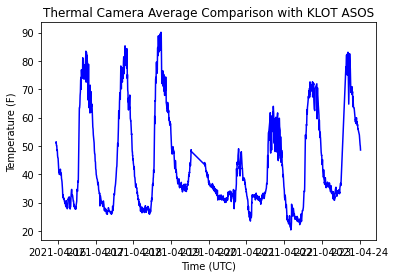

In [98]:
plt.plot(image_time, temp_avgf, color = 'blue')
plt.plot(image_time, temp_medf, color = 'purple')

plt.xlabel('Time (UTC)')
#plt.xticks(time[np.arange(0, len(time), 144)])
plt.ylabel('Temperature (F)')

plt.title('Thermal Camera Average Comparison with KLOT ASOS')
